# Data Analysis

In [1]:
import os, glob, re, spacy, nltk
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy.attrs

%matplotlib inline

from sklearn.utils import shuffle
from spacy import displacy
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from collections import Counter
from scipy import stats
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bleuze3u\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Corpus loading

In [2]:
# from google.colab import drive
# drive.mount('/content/MyDrive')
# root_path = 'MyDrive/datascience/data/' 
# US_Presidents= [file for file in os.listdir("MyDrive/MyDrive/datascience/data/US_Presidents") if re.match(re.compile(".*.txt"), file)]
# Categories=["US_Presidents","Women_Scientists"]
# articles_Presidents = []
# for i in US_Presidents:
#     groups = re.match(re.compile("(.*).txt"), i).groups()
#     name, title,category = i, groups[0], Categories[0]
#     articles_Presidents.append([name, title, category])
# data_Presidents = []

# for x in articles_Presidents:
#     with open("MyDrive/MyDrive/datascience/data/US_Presidents/"+ x[0], "r", encoding="utf-8") as file:
#         content = file.read()
#         splited_data = content.splitlines()
#         content = ''.join(splited_data)
#         data_Presidents.append([ x[1],x[2], content])
# df_Presidents  = pd.DataFrame(data_Presidents, columns=["title", "category","text"])


# Women_Scientists= [file for file in os.listdir("MyDrive/MyDrive/datascience/data/Women_Scientists") if re.match(re.compile(".*.txt"), file)]
# Categories=["US_Presidents","Women_Scientists"]
# articles_Scientists = []
# for e in Women_Scientists:
#     groups = re.match(re.compile("(.*).txt"), e).groups()
#     name, title,category = e, groups[0], Categories[1]
#     articles_Scientists.append([name, title, category])

#     data_Scientists = []

# for y in articles_Scientists :
#     with open("MyDrive/MyDrive/datascience/data/Women_Scientists/"+ y[0], "r", encoding="utf-8") as file:
#         content = file.read()
#         splited_data = content.splitlines()
#         content = ''.join(splited_data)
#         data_Scientists.append([y[1], y[2], content])

# df_Scientists  = pd.DataFrame(data_Scientists, columns=["title", "category","text"])

# president_df = df_Presidents[df_Presidents['category'] == 'US_Presidents']
# scientists_df = df_Scientists[df_Scientists['category'] == 'Women_Scientists']
# sample_scientists_df = scientists_df.sample(n=328,random_state=42)
# sample_presidents_df = president_df.sample(n=45,random_state=42)
# pre_sci_df = pd.concat([sample_presidents_df, sample_scientists_df], ignore_index=True)


In [3]:
pre_sci_df = pd.read_csv("../data/all_data.csv")
pre_sci_df

,title,content,category
0,Eva Syková,Eva Syková (born 1944) is a Czech neuroscienti...,Women_Scientists
1,Maria Kovacs,Maria Kovacs is an American psychologist and a...,Women_Scientists
2,Joanne Johnson,"\nJoanne S. Johnson (born 1977, Birmingham, né...",Women_Scientists
3,Hua Eleanor Yu,Hua Eleanor Yu is the inaugural Billy and Audr...,Women_Scientists
4,Manju Ray,Manju Ray was an Indian scientist specializing...,Women_Scientists
...,...,...,...
373,Jennifer Thomson,"\nJennifer Ann Thomson (born June 16, 1947) is...",Women_Scientists
374,William McKinley,"\nWilliam McKinley (January 29, 1843 – Septemb...",US_Presidents
375,Priyamvada Natarajan,\nPriyamvada (Priya) Natarajan is a professor ...,Women_Scientists
376,Afërdita Veveçka Priftaj,\nAfërdita Veveçka Priftaj (21 January 1948 – ...,Women_Scientists


## 2. Vocabulary analysis  
### 2.1 Pre-processing  

We shall now clean the raw content of the articles. In this section, we will:
- remove non alpa-numeric symbols like \\n, \\t, _, etc.  
- remove excessive whitespaces (2 or more consecutive whitespaces)  
- remove quotation references (e.g [12])
- lowercase every word  

We will then, after analysing the tokens contained in the text:
- remove punctuation
- remove stopwords, because they are not informative about the semantics of the articles

In [45]:
# A function to remove underscores from the text
def remove_underscores(text:str)->str:
    return text.replace("_", " ")

# A function to remove excess whitespaces from the text
def remove_excess_whitespace(text:str)->str:
    return " ".join(text.split())

# A function to remove \n or \t from the text
def remove_newline_tab(text:str)->str:
    return text.replace("\n", " ").replace("\t", " ")

# A function to remove quotations from the text
def remove_quotations(text:str)->str:
    return re.sub(re.compile("\[\d*\]"), "", text)

# A function to clean the text by calling the above functions
def clean_text(text:str)->str:
    text = remove_underscores(text)
    text = remove_newline_tab(text)
    text = remove_quotations(text)
    text = remove_excess_whitespace(text)
    text = text.lower()
    return text

In [46]:
pre_sci_df["clean_text"] = pre_sci_df["content"].apply(clean_text)
pre_sci_df

,title,content,category,clean_text,tokens
0,Eva Syková,Eva Syková (born 1944) is a Czech neuroscienti...,Women_Scientists,eva syková (born 1944) is a czech neuroscienti...,"[eva, syková, born, czech, neuroscientist, res..."
1,Maria Kovacs,Maria Kovacs is an American psychologist and a...,Women_Scientists,maria kovacs is an american psychologist and a...,"[maria, kovacs, american, psychologist, academ..."
2,Joanne Johnson,"\nJoanne S. Johnson (born 1977, Birmingham, né...",Women_Scientists,"joanne s. johnson (born 1977, birmingham, née ...","[joanne, s., johnson, born, birmingham, née, g..."
3,Hua Eleanor Yu,Hua Eleanor Yu is the inaugural Billy and Audr...,Women_Scientists,hua eleanor yu is the inaugural billy and audr...,"[hua, eleanor, yu, inaugural, billy, audrey, l..."
4,Manju Ray,Manju Ray was an Indian scientist specializing...,Women_Scientists,manju ray was an indian scientist specializing...,"[manju, ray, indian, scientist, specializing, ..."
...,...,...,...,...,...
373,Jennifer Thomson,"\nJennifer Ann Thomson (born June 16, 1947) is...",Women_Scientists,"jennifer ann thomson (born june 16, 1947) is a...","[jennifer, ann, thomson, born, june, south, af..."
374,William McKinley,"\nWilliam McKinley (January 29, 1843 – Septemb...",US_Presidents,"william mckinley (january 29, 1843 – september...","[william, mckinley, january, september, th, pr..."
375,Priyamvada Natarajan,\nPriyamvada (Priya) Natarajan is a professor ...,Women_Scientists,priyamvada (priya) natarajan is a professor in...,"[priyamvada, priya, natarajan, professor, depa..."
376,Afërdita Veveçka Priftaj,\nAfërdita Veveçka Priftaj (21 January 1948 – ...,Women_Scientists,afërdita veveçka priftaj (21 january 1948 – 4 ...,"[afërdita, veveçka, priftaj, january, july, al..."


In [47]:
# Load the spacy model
# !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# Break a text into a list of tokens 
def get_tokens(text):
    """A function that returns a list of tokens from a text, after removing stopwords and punctuations"""
    tokens = []
    doc = nlp(text)
    for token in doc:
        if token.is_stop == False and token.is_punct == False:
            tokens.append(token.text)
    return tokens

In [48]:
pre_sci_df["tokens"] = pre_sci_df["clean_text"].apply(get_tokens)
pre_sci_df

,title,content,category,clean_text,tokens
0,Eva Syková,Eva Syková (born 1944) is a Czech neuroscienti...,Women_Scientists,eva syková (born 1944) is a czech neuroscienti...,"[eva, syková, born, 1944, czech, neuroscientis..."
1,Maria Kovacs,Maria Kovacs is an American psychologist and a...,Women_Scientists,maria kovacs is an american psychologist and a...,"[maria, kovacs, american, psychologist, academ..."
2,Joanne Johnson,"\nJoanne S. Johnson (born 1977, Birmingham, né...",Women_Scientists,"joanne s. johnson (born 1977, birmingham, née ...","[joanne, s., johnson, born, 1977, birmingham, ..."
3,Hua Eleanor Yu,Hua Eleanor Yu is the inaugural Billy and Audr...,Women_Scientists,hua eleanor yu is the inaugural billy and audr...,"[hua, eleanor, yu, inaugural, billy, audrey, l..."
4,Manju Ray,Manju Ray was an Indian scientist specializing...,Women_Scientists,manju ray was an indian scientist specializing...,"[manju, ray, indian, scientist, specializing, ..."
...,...,...,...,...,...
373,Jennifer Thomson,"\nJennifer Ann Thomson (born June 16, 1947) is...",Women_Scientists,"jennifer ann thomson (born june 16, 1947) is a...","[jennifer, ann, thomson, born, june, 16, 1947,..."
374,William McKinley,"\nWilliam McKinley (January 29, 1843 – Septemb...",US_Presidents,"william mckinley (january 29, 1843 – september...","[william, mckinley, january, 29, 1843, septemb..."
375,Priyamvada Natarajan,\nPriyamvada (Priya) Natarajan is a professor ...,Women_Scientists,priyamvada (priya) natarajan is a professor in...,"[priyamvada, priya, natarajan, professor, depa..."
376,Afërdita Veveçka Priftaj,\nAfërdita Veveçka Priftaj (21 January 1948 – ...,Women_Scientists,afërdita veveçka priftaj (21 january 1948 – 4 ...,"[afërdita, veveçka, priftaj, 21, january, 1948..."


### 2.2 Vocabulary extraction : frequent words and word clouds

#### 50 most frequent words and word cloud for *US_Presidents*

In [49]:
# Global text for Presidents
Presidents = pre_sci_df[pre_sci_df["category"] == "US_Presidents"]["clean_text"].str.cat(sep=" ")

# List of tokens for Presidents
Presidents_tokens = []

for tokens in pre_sci_df[pre_sci_df["category"] == "US_Presidents"]["tokens"]:
    for token in tokens:
        Presidents_tokens.append(token)

# Vocabulary for Presidents
Presidents_vocabulary = set(Presidents_tokens)

print(Presidents_tokens[:20])

['george', 'walker', 'bush', 'born', 'july', '6', '1946', 'american', 'politician', 'served', '43rd', 'president', 'united', 'states', '2001', '2009', 'member', 'republican', 'party', 'previously']


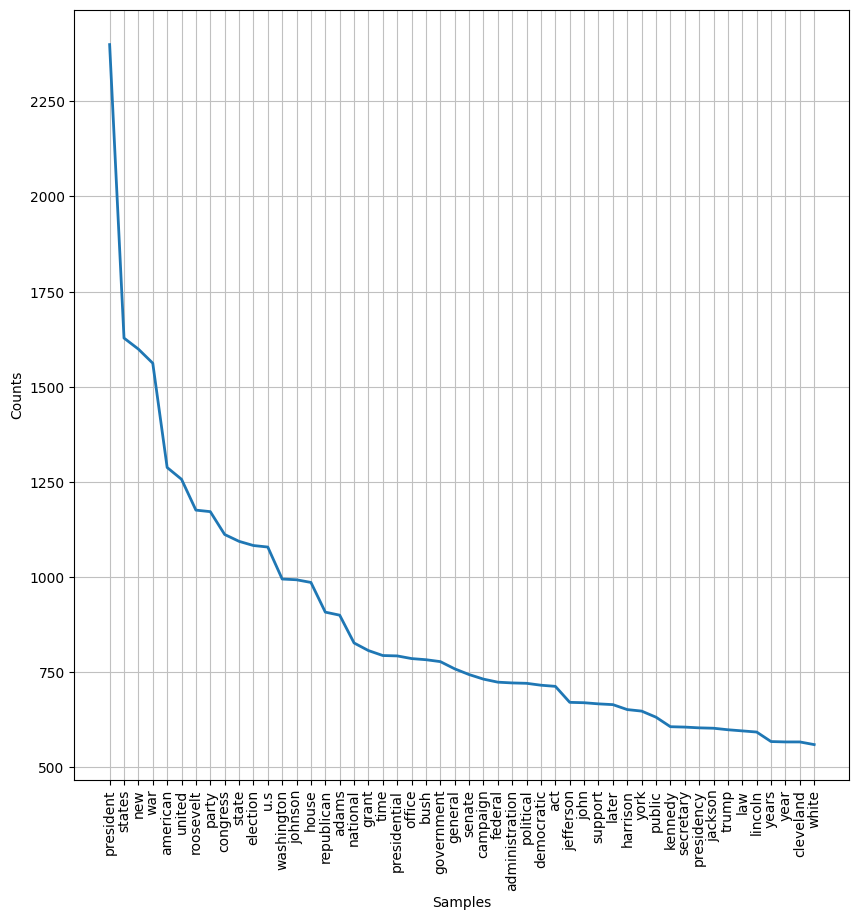

In [50]:
fig = plt.figure(figsize=(10, 10))
frequency_dist = nltk.FreqDist(Presidents_tokens)
frequency_dist.plot(50)
# fig.savefig("../data/plots/50_most_frequent_words_US_Presidents.png", bbox_inches="tight")
plt.show()

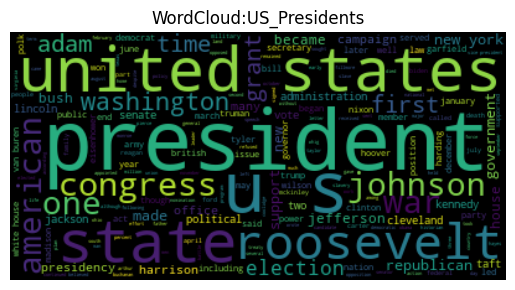

In [51]:
wordcloud = WordCloud().generate(Presidents)
plt.title("WordCloud:US_Presidents")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.savefig("../data/plots/WordCloud_US_Presidents.png", bbox_inches="tight")
plt.show()

#### 50 most frequent words and word cloud for *Women_Scientists*

In [52]:
# Global text for Scientists
Scientists = pre_sci_df[pre_sci_df["category"] == "Women_Scientists"]["clean_text"].str.cat(sep=" ")

# List of tokens for Scientists
Scientists_tokens = []

for tokens in pre_sci_df[pre_sci_df["category"] == "Women_Scientists"]["tokens"]:
    for token in tokens:
        Scientists_tokens.append(token)

# Vocabulary for Scientists
Scientists_vocabulary = set(Scientists_tokens)

print(Scientists_tokens[:20])

['eva', 'syková', 'born', '1944', 'czech', 'neuroscientist', 'research', 'focused', 'origins', 'mechanisms', 'maintenance', 'ionic', 'volume', 'homeostasis', 'cns', 'role', 'extrasynaptic', 'transmission', 'spinal', 'cord']


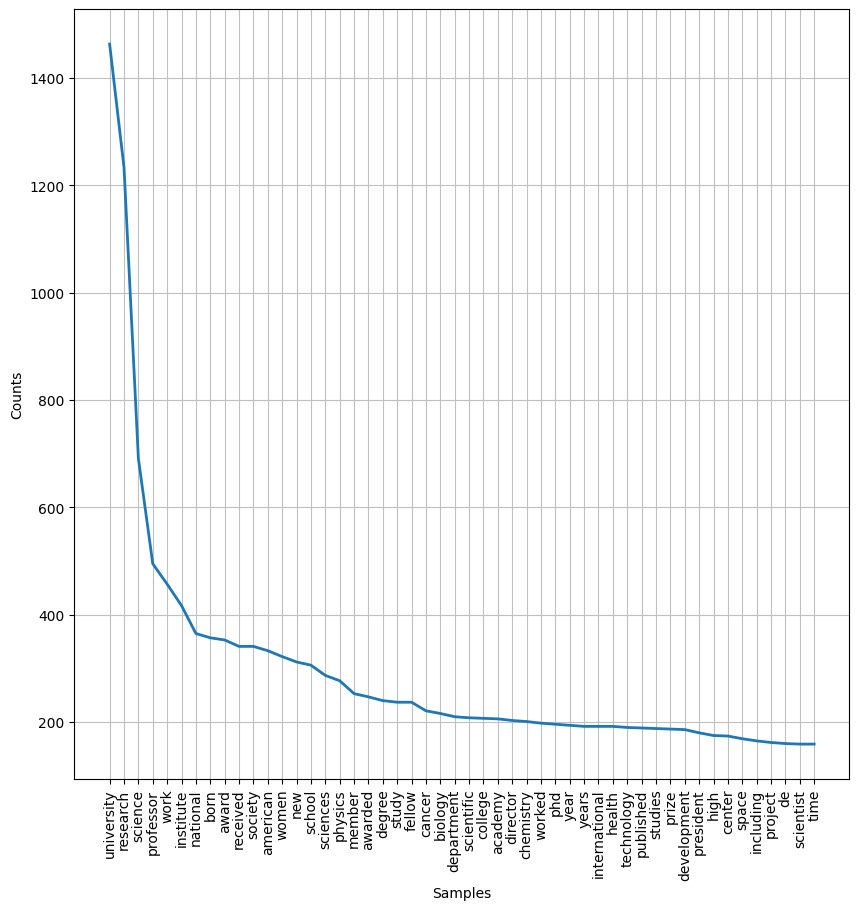

In [53]:
fig = plt.figure(figsize=(10, 10))
frequency_dist = nltk.FreqDist(Scientists_tokens)
frequency_dist.plot(50)
# plt.title("50 most frequent words:Women_Scientists")
# fig.savefig("../data/plots/50_most_frequent_words_Women_Scientists.png", bbox_inches="tight")
plt.show()

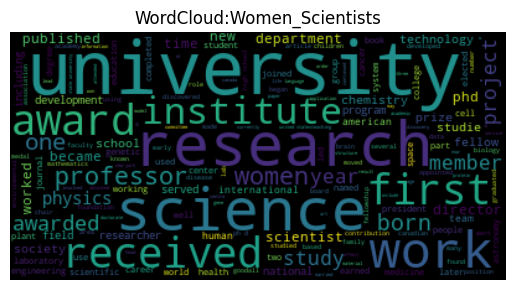

In [54]:
wordcloud = WordCloud().generate(Scientists)
plt.title("WordCloud:Women_Scientists")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.savefig("../data/plots/WordCloud_Women_Scientists.png", bbox_inches="tight")
plt.show()

## 3. Sentences extraction  
In this part, we'll give some statistics about the sentences for each category's articles. We'll answer these questions:  
- How many sentences are there for each category ?  
- What are the minimum, maximum, and average number of sentences per article for each category ?  
- What are the minimum, maximum, and average number of tokens per sentence for each category ?

In [55]:
pres_sentences = sent_tokenize(Presidents)
sci_sentences = sent_tokenize(Scientists)

print(f"- Number of sentence for category 'US_Presidents': {len(pres_sentences)}")
print(f"- Number of sentence for category 'Women_Scientists': {len(sci_sentences)}")

- Number of sentence for category 'US_Presidents': 23506
- Number of sentence for category 'Women_Scientists': 6951


In [57]:
# A few sentences from the category 'US_Presidents'
pres_sentences[:5]

['george walker bush (born july 6, 1946) is an american politician who served as the 43rd president of the united states from 2001 to 2009. a member of the republican party, he previously served as the 46th governor of texas from 1995 to 2000. the son of the 41st president, george h. w. bush, bush flew warplanes in the texas air national guard while in his twenties.',
 'after graduating from harvard business school in 1975, he worked in the oil industry.',
 'he later co-owned the texas rangers of major league baseball before being elected governor of texas in 1994. as governor, bush successfully sponsored legislation for tort reform, increased education funding, set higher standards for schools, and reformed the criminal justice system.',
 "he also helped make texas the united states' leading producer of wind-powered electricity.",
 'in the 2000 united states presidential election, bush defeated democratic incumbent vice president al gore, despite losing the popular vote after a narrow

In [58]:
# A few sentences from the category 'Women_Scientists'
sci_sentences[:5]

['eva syková (born 1944) is a czech neuroscientist whose research focused on the origins, mechanisms and maintenance of ionic and volume homeostasis in the cns and the role of extrasynaptic transmission, spinal cord injury.',
 'she is currently leading several clinical studies, including a phase i/ii study in patients with spinal cord injury as well as ongoing clinical studies of patients with als and ischemic leg injury.',
 'she was director of institute of experimental medicine and the head of the center for cell therapy and tissue repair at charles university in prague.',
 'eva syková is author of 421 publications and co-holder of 7 patents with an h-index of 50. this article about a czech scientist is a stub.',
 'you can help wikipedia by expanding it.this neuroscience article is a stub.']

### Min/max/avg number of sentences per article for each category

In [61]:
pre_sci_df["nb_of_sentences"] = pre_sci_df["content"].apply(lambda x: len(sent_tokenize(x)))
pre_sci_df

,title,content,category,clean_text,tokens,nb_of_sentences
0,Eva Syková,Eva Syková (born 1944) is a Czech neuroscienti...,Women_Scientists,eva syková (born 1944) is a czech neuroscienti...,"[eva, syková, born, 1944, czech, neuroscientis...",7
1,Maria Kovacs,Maria Kovacs is an American psychologist and a...,Women_Scientists,maria kovacs is an american psychologist and a...,"[maria, kovacs, american, psychologist, academ...",13
2,Joanne Johnson,"\nJoanne S. Johnson (born 1977, Birmingham, né...",Women_Scientists,"joanne s. johnson (born 1977, birmingham, née ...","[joanne, s., johnson, born, 1977, birmingham, ...",22
3,Hua Eleanor Yu,Hua Eleanor Yu is the inaugural Billy and Audr...,Women_Scientists,hua eleanor yu is the inaugural billy and audr...,"[hua, eleanor, yu, inaugural, billy, audrey, l...",24
4,Manju Ray,Manju Ray was an Indian scientist specializing...,Women_Scientists,manju ray was an indian scientist specializing...,"[manju, ray, indian, scientist, specializing, ...",12
...,...,...,...,...,...,...
373,Jennifer Thomson,"\nJennifer Ann Thomson (born June 16, 1947) is...",Women_Scientists,"jennifer ann thomson (born june 16, 1947) is a...","[jennifer, ann, thomson, born, june, 16, 1947,...",13
374,William McKinley,"\nWilliam McKinley (January 29, 1843 – Septemb...",US_Presidents,"william mckinley (january 29, 1843 – september...","[william, mckinley, january, 29, 1843, septemb...",517
375,Priyamvada Natarajan,\nPriyamvada (Priya) Natarajan is a professor ...,Women_Scientists,priyamvada (priya) natarajan is a professor in...,"[priyamvada, priya, natarajan, professor, depa...",22
376,Afërdita Veveçka Priftaj,\nAfërdita Veveçka Priftaj (21 January 1948 – ...,Women_Scientists,afërdita veveçka priftaj (21 january 1948 – 4 ...,"[afërdita, veveçka, priftaj, 21, january, 1948...",16


In [86]:
sentences_counts = pre_sci_df.groupby("category")["nb_of_sentences"].describe()
sentences_counts

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
US_Presidents,46.0,558.500000,144.413103,328.0,451.5,531.0,646.0,900.0
Women_Scientists,332.0,24.521084,19.987976,5.0,14.0,20.0,28.0,214.0


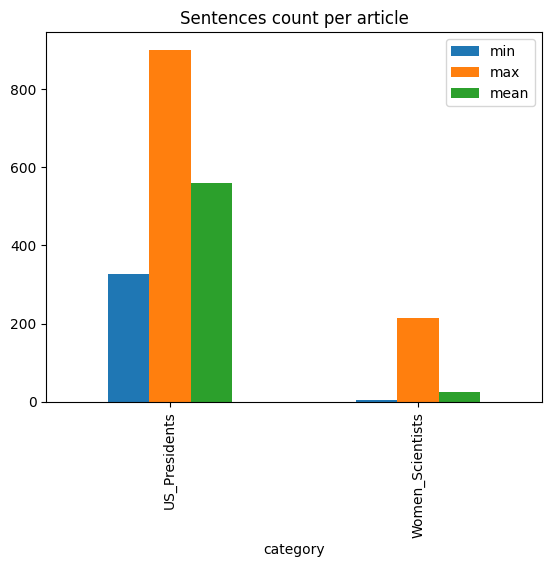

In [84]:
# Plot histogram of the number of sentences per article
sentences_counts[["min", "max", "mean"]].plot(kind="bar", title="Sentences count per article")
# plt.savefig("../data/plots/Sentences_count_per_article.png", bbox_inches="tight")
plt.show()

A remark: when we use the sum of sentences counts for each category, we don't find the same exact total counts as before. This is because, before, we artifically reconstitute a global text with all articles, only joining sentences with whitespaces.

In [85]:
sentences_sum = pre_sci_df.groupby("category")["nb_of_sentences"].sum()
sentences_sum

category
US_Presidents       25691
Women_Scientists     8141
Name: nb_of_sentences, dtype: int64

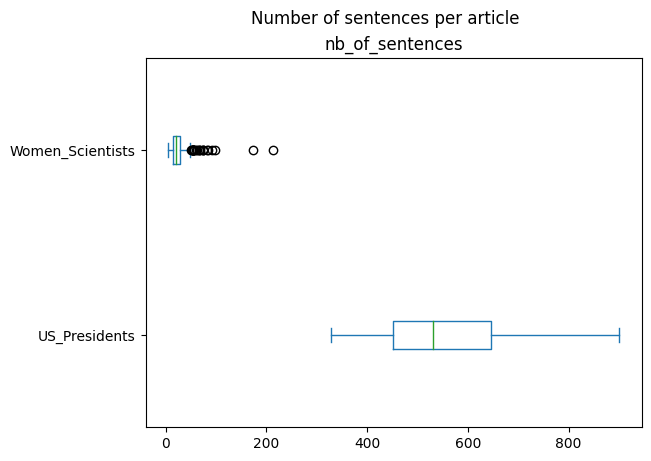

In [114]:
pre_sci_df[["nb_of_sentences", "category"]].plot(kind = "box", by = "category", title = "Number of sentences per article", vert=False)
plt.savefig("../data/plots/Boxplot_Sentences_count_per_article.png", bbox_inches="tight")
plt.show()

### Min/max/avg number of tokens per sentence for each category 
# [TO DO]

# Extracting the token of each category

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [29]:
nlp.max_length = 4787754

In [32]:
def get_tokens(cat):
    subframe = pre_sci_df[pre_sci_df['category'] == cat]
    texts = subframe['clean_text'].str.cat(sep=" ")
    doc = nlp(texts)
    words = [word.text for word in doc]
    vocab = list(set(words))
    print(str(len(vocab))+" tokens in category "+cat)
    return(" ". join(vocab))


vocabs = []
for c in Categories:
    vocab = get_tokens(c)
    vocabs.append(vocab)

39521 tokens in category US_Presidents
21490 tokens in category Women_Scientists


In [33]:
data_corpus = {'CATEGORY':Categories,'VOCABULARY':vocabs}
data_df = pd.DataFrame(data_corpus) 
data_df["VOCAB SIZE"] = data_df["VOCABULARY"].str.split().apply(len)
data_df

,CATEGORY,VOCABULARY,VOCAB SIZE
0,US_Presidents,lemann grayson force.[218]thousands foresaw ho...,39513
1,Women_Scientists,apl 1982.[1 biology[7 undermining harmful אסנת...,21483


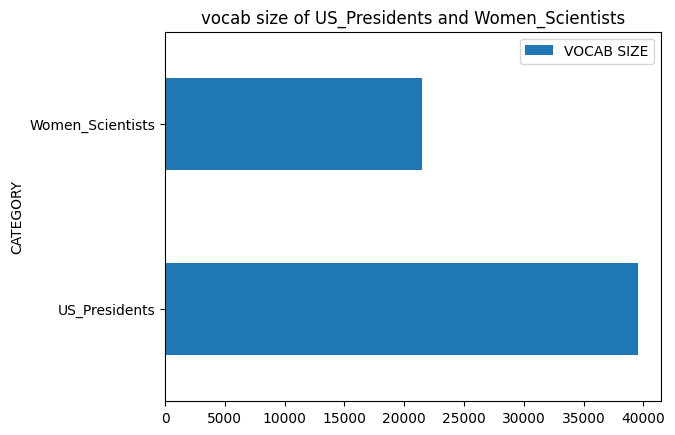

In [28]:
ax = data_df.plot.barh(x='CATEGORY', y='VOCAB SIZE',title="vocab size of US_Presidents and Women_Scientists", rot=0)

# Min/max/avg number of token occurrences per sentence:US_Presidents

In [ ]:

token_sen_pre = []
for sent in number_sent_pre:
    nltk_tokens = nltk.word_tokenize(sent)
    
    token_sen_pre.append(len(nltk_tokens))

token_sen_pre




In [45]:

print("Min number of token occurrences per sentence:US_Presidents: ", min(token_sen_pre))
print("Max number of token occurrences per sentence:US_Presidents: ", max(token_sen_pre))
print("Avg number of token occurrences per sentence:US_Presidents ",sum(token_sen_pre)/len(token_sen_pre))

Min number of token occurrences per sentence:US_Presidents:  1
Max number of token occurrences per sentence:US_Presidents:  195
Avg number of token occurrences per sentence:US_Presidents  30.09214523361782


# Min/max/avg number of token occurrences per sentence:Women_Scientists

In [ ]:

token_sen_pre = []
for sent in number_sent_sci:
    nltk_tokens = nltk.word_tokenize(sent)
    
    token_sen_pre.append(len(nltk_tokens))

token_sen_pre


In [44]:

print("Min number of token occurrences per sentence:Women_Scientists: ", min(token_sen_pre))
print("Max number of token occurrences per sentence:US_Women_Scientists: ", max(token_sen_pre))
print("Avg number of token occurrences per sentence:US_Women_Scientists ",sum(token_sen_pre)/len(token_sen_pre))

Min number of token occurrences per sentence:Women_Scientists:  1
Max number of token occurrences per sentence:US_Women_Scientists:  195
Avg number of token occurrences per sentence:US_Women_Scientists  30.09214523361782


# Bonus

# Named Entities (NER), NOUN, VERB, ADJ: US_Presidents

In [ ]:
text = pre_sci_df['text'].where(pre_sci_df['category']=="US_Presidents").str.cat(sep=' ')
doc = nlp(text)
ents = [(e.label_) for e in doc.ents]
print(ents)

displacy.render(doc, style='ent', jupyter=True)

In [31]:
NER_pre=Counter(ents).most_common(20)

In [32]:
spacy.explain("TIME")

'Times smaller than a day'

In [33]:
df_NER_pre = pd.DataFrame(NER_pre, columns=['NER', 'count_NER'])

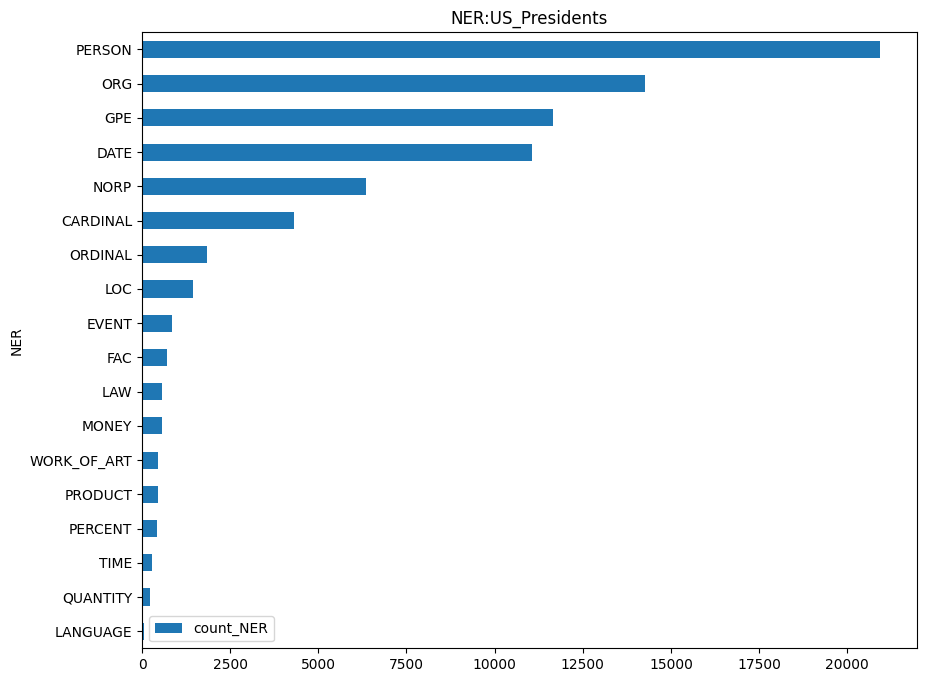

In [34]:
df_NER_pre.plot.barh(x='NER', y='count_NER', title="NER:US_Presidents", figsize=(10,8)).invert_yaxis()

In [ ]:
doc_pre = nlp(pre_sci_df['text'].where(pre_sci_df['category']=="US_Presidents").str.cat(sep=' '))
for token in doc_pre :
    print(token.text, token.pos_)

In [36]:

nouns = [token.text for token in doc_pre if token.pos_ == 'NOUN']
verbs = [token.text for token in doc_pre if token.pos_ == 'VERB']
adjs=[token.text for token in doc_pre if token.pos_ == 'ADJ']
nouns_tally = Counter(nouns)
verbs_tally = Counter(verbs)
adjs_tally=Counter(adjs)

df_nouns_pre = pd.DataFrame(nouns_tally.most_common(), columns=['noun', 'count_noun'])
df_verbs_pre = pd.DataFrame(verbs_tally.most_common(), columns=['verb', 'count_verb'])
df_adjs_pre = pd.DataFrame(nouns_tally.most_common(), columns=['adjs', 'count_adj'])

In [37]:
df_pre = pd.concat([df_nouns_pre, df_verbs_pre,df_adjs_pre,df_NER_pre], axis = 1)
df_pre.head()

,noun,count_noun,verb,count_verb,adjs,count_adj,NER,count_NER
0,president,1382,had,835.0,president,1382,PERSON,20932.0
1,election,928,became,668.0,election,928,ORG,14255.0
2,time,721,made,629.0,time,721,GPE,11644.0
3,war,691,won,488.0,war,691,DATE,11058.0
4,state,677,including,472.0,state,677,NORP,6355.0


# Named Entities (NER), NOUN, VERB, ADJ: Women_Scientists

In [ ]:
text = pre_sci_df['text'].where(pre_sci_df['category']=="Women_Scientists").str.cat(sep=' ')
doc = nlp(text)
ents = [(e.label_) for e in doc.ents]
print(ents)

displacy.render(doc, style='ent', jupyter=True)

In [39]:
NER_sci=Counter(ents).most_common(20)

In [40]:
df_NER_sci = pd.DataFrame(NER_sci, columns=['NER', 'count_NER'])

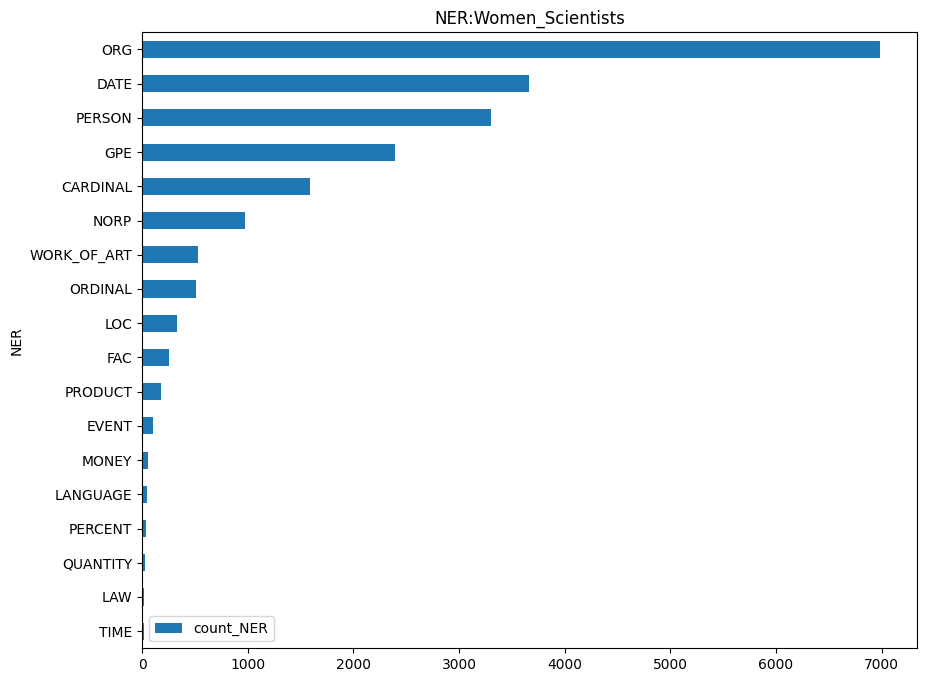

In [41]:
df_NER_sci.plot.barh(x='NER', y='count_NER', title="NER:Women_Scientists", figsize=(10,8)).invert_yaxis()

In [ ]:
doc_sci = nlp(pre_sci_df['text'].where(pre_sci_df['category']=="Women_Scientists").str.cat(sep=' '))
for token in doc_sci :
    print(token.text, token.pos_)

In [43]:

nouns = [token.text for token in doc_sci if token.pos_ == 'NOUN']
verbs = [token.text for token in doc_sci if token.pos_ == 'VERB']
adjs=[token.text for token in doc_sci if token.pos_ == 'ADJ']
nouns_tally = Counter(nouns)
verbs_tally = Counter(verbs)
adjs_tally=Counter(adjs)

df_nouns_sci = pd.DataFrame(nouns_tally.most_common(), columns=['noun', 'count_noun'])
df_verbs_sci = pd.DataFrame(verbs_tally.most_common(), columns=['verb', 'count_verb'])
df_adjs_sci = pd.DataFrame(nouns_tally.most_common(), columns=['adjs', 'count_adj'])

In [44]:
df_sci = pd.concat([df_nouns_sci, df_verbs_sci,df_adjs_sci,df_NER_sci], axis = 1)
df_sci.head()

,noun,count_noun,verb,count_verb,adjs,count_adj,NER,count_NER
0,research,745,born,335.0,research,745,ORG,6985.0
1,work,401,received,335.0,work,401,DATE,3658.0
2,professor,277,awarded,247.0,professor,277,PERSON,3306.0
3,member,228,worked,196.0,member,228,GPE,2391.0
4,degree,223,became,194.0,degree,223,CARDINAL,1594.0
